### Load packages

In [5]:
suppressPackageStartupMessages(library(tidyverse))

### Load count data and prepare for DESeq2

#### Load ENCODE guideQuant files, select guideID, type of guide, and read counts

The dataframes are named as 'timepoint+effector.replicate#' (ex. CRISPRi Day 21, replicate 1 --> t21i.rep1).

In [6]:
plasmid <- read_tsv("guidequant/Plasmid_Bassik_guide_quantifications.bed", col_names = FALSE, show_col_types = FALSE) %>%
  mutate(grna_id = X7, type = X16, plasmid = X5) %>%
  select(grna_id, type, plasmid) 

In [7]:
head(plasmid,n=3)

grna_id,type,plasmid
<chr>,<chr>,<dbl>
chrX:48686620-48686623,tiling,208
chrX:48686624-48686627,tiling,189
chrX:48686632-48686635,tiling,288


In [8]:
t7i <- read_tsv("guidequant/T7_I_Bassik_guide_quantifications.bed", col_names = FALSE, show_col_types = FALSE) %>%
  mutate(grna_id = X7, type = X16, t7i = X5) %>%
  select(grna_id, type, t7i) 

In [9]:
t21i.rep1 <- read_tsv("guidequant/T21_I_R1_Bassik_guide_quantifications.bed", col_names = FALSE, show_col_types = FALSE) %>%
  mutate(grna_id = X7, type = X16, t21i.rep1 = X5) %>%
  select(grna_id, type, t21i.rep1) 

In [10]:
t21i.rep2 <- read_tsv("guidequant/T21_I_R2_Bassik_guide_quantifications.bed", col_names = FALSE, show_col_types = FALSE) %>%
  mutate(grna_id = X7, type = X16, t21i.rep2 = X5) %>%
  select(grna_id, type, t21i.rep2) 

#### Combine replicates into one df

In [11]:
df.i <- plasmid %>%
  filter(grepl("NT", grna_id) | grepl("chr", grna_id)) %>%
  filter(grna_id %in% t7i$grna_id) %>%
  left_join(t7i %>% select(-type), by = "grna_id") %>%
  left_join(t21i.rep1 %>% select(-type), by = "grna_id") %>%
  left_join(t21i.rep2 %>% select(-type), by = "grna_id")

dim(df.i) # same number of rows as original replicates

[1] 9977    6

#### Check for duplicates (sgRNAs with >1 value for count in at least one replicate)

In [12]:
df.i[duplicated(df.i$grna_id),]

grna_id,type,plasmid,t7i,t21i.rep1,t21i.rep2
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>


#### Make metadata for DESeq2

In [13]:
samples.i <- colnames(df.i %>% select(-grna_id, -type))
meta.i <- data.frame(sample = samples.i, group = c("plasmid","day7","day21","day21"))
meta.i

sample,group
<chr>,<chr>
plasmid,plasmid
t7i,day7
t21i.rep1,day21
t21i.rep2,day21


#### Prepare counts and metadata for summarized experiment

In [14]:
df.i.clean <- as.matrix(df.i %>% select(-type, -grna_id))
row.names(df.i.clean) <- df.i$grna_id
coldata.i <- meta.i[,c("sample","group")]

### Run DESeq2

In [15]:
suppressPackageStartupMessages(library(DESeq2))

#### Make DESeq2 summarized experiment

In [16]:
se.i <- DESeqDataSetFromMatrix(
  countData = df.i.clean,
  colData = coldata.i,
  design = ~ group
)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


#### Run DESeq2

In [17]:
dds.i <- DESeq(se.i)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



#### Generate results object

In [18]:
res.i.plasmidvsd7 <- results(dds.i, contrast = c("group","day7","plasmid"))
res.i.plasmidvsd21 <- results(dds.i, contrast = c("group","day21","plasmid")) 
res.i.d7vsd21 <- results(dds.i, contrast = c("group","day21","day7")) 

#### Summary of results

In [19]:
summary(res.i.plasmidvsd7)


out of 9977 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 33, 0.33%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [20]:
summary(res.i.plasmidvsd21)


out of 9977 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 11, 0.11%
LFC < 0 (down)     : 479, 4.8%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [21]:
summary(res.i.d7vsd21)


out of 9977 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2, 0.02%
LFC < 0 (down)     : 295, 3%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



#### Add grna_id to DESeq2 results

In [23]:
krab.plasmid.d7 <- as.data.frame(res.i.plasmidvsd7, row.names = NULL)
krab.plasmid.d7$grna_id <- rownames(res.i.plasmidvsd7)
krab.plasmid.d7 <- krab.plasmid.d7 %>% left_join(plasmid %>% select(grna_id, type) %>% distinct(), by = "grna_id")

krab.plasmid.d21 <- as.data.frame(res.i.plasmidvsd21, row.names = NULL)
krab.plasmid.d21$grna_id <- rownames(res.i.plasmidvsd21)
krab.plasmid.d21 <- krab.plasmid.d21 %>% left_join(plasmid %>% select(grna_id, type) %>% distinct(), by = "grna_id")

krab.d7d21 <- as.data.frame(res.i.d7vsd21, row.names = NULL)
krab.d7d21$grna_id <- rownames(res.i.d7vsd21)
krab.d7d21 <- krab.d7d21 %>% left_join(plasmid %>% select(grna_id, type) %>% distinct(), by = "grna_id")

#### Save results
Combine contrast results into one df for each type of screen

In [24]:
krab.res <- 
  krab.plasmid.d7 %>%
  dplyr::rename_with(~ paste("d7.vs.plasmid", .x, sep = "."), baseMean:padj) %>%
  left_join(
    krab.plasmid.d21 %>%
      rename_with(~ paste("d21.vs.plasmid", .x, sep = "."), baseMean:padj),
    by = c("grna_id","type"))  %>%
  left_join(
    krab.d7d21 %>%
      rename_with(~ paste("d21.vs.d7", .x, sep = "."), baseMean:padj),
    by = c("grna_id","type"))  %>%
  dplyr::select(grna_id, type, d7.vs.plasmid.baseMean:d7.vs.plasmid.padj, d7.vs.plasmid.baseMean:d21.vs.d7.padj)

In [25]:
write_tsv(krab.res, "deseq2_results/tyckoGATA1krabinterference.deseq2.results.tsv", col_names = TRUE)

### Visualization and QC

In [26]:
vsd <- vst(dds.i, blind = FALSE)
rld <- rlog(dds.i, blind = FALSE)
ntd <- normTransform(dds.i) # this gives log2(n+1)

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



In [29]:
# meanSdPlot(assay(ntd))

In [30]:
# meanSdPlot(assay(vsd))

In [31]:
# meanSdPlot(assay(rld))

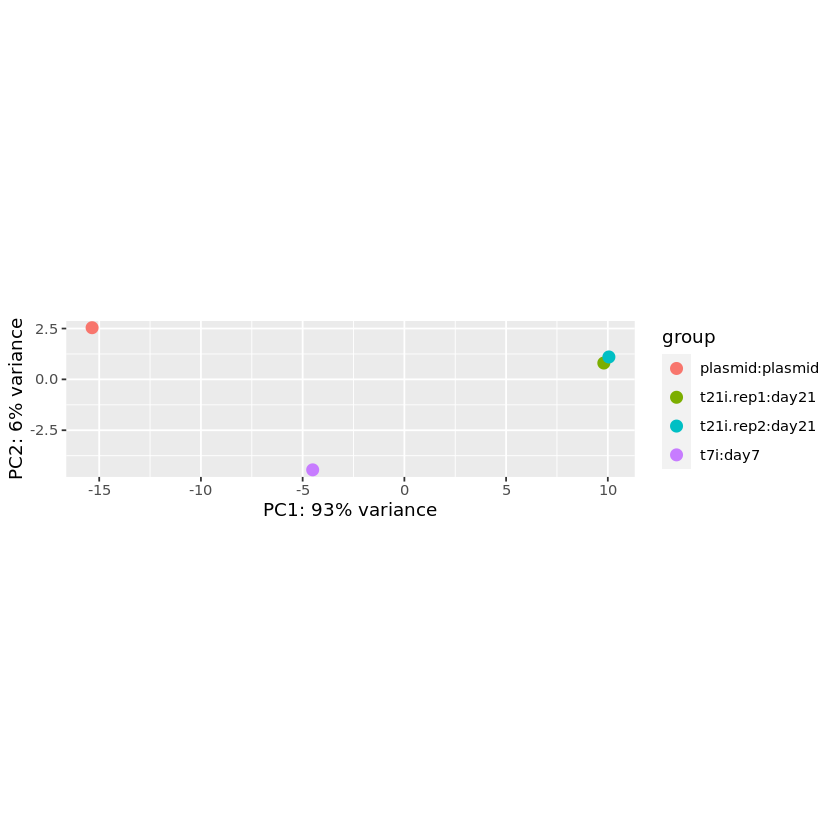

In [32]:
plotPCA(vsd, intgroup=c("sample", "group"))

In [33]:
# sampleDists <- dist(t(assay(vsd)))
# sampleDistMatrix <- as.matrix(sampleDists)
# rownames(sampleDistMatrix) <- paste(vsd$sample, vsd$type, sep="-")
# colnames(sampleDistMatrix) <- paste(vsd$sample, vsd$type, sep="-") # change to 'NULL' to get rid of bottom labels
# colors <- colorRampPalette(rev(brewer.pal(9, "Blues")))(255)
# pheatmap(sampleDistMatrix,
#          clustering_distance_rows=sampleDists,
#          clustering_distance_cols=sampleDists,
#          col=colors,
#          main = "Tycko GATA1 CRISPR interference screen")

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'rev': could not find function "brewer.pal"
